# Risk Measures and Monte Carlo Simulations

We will analyze historical returns of asset classes to calculate risk measurements, which will then be used to simulate and evaluate a rules-based investment approach using Monte Carolo simulations.

This project will focus on the below questions:

- How can we evaluate historical asset class returns data?
- How do we calculate kay risk metrics?
- How can we best evaluate an investing strategy?
- How can we visualize wealth paths?

In [192]:
# Importing pandas and numpy for data analysis
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import math

# Importing pandas tools for data
import pandas_datareader as pdr
from pandas_datareader import data as web
from datetime import datetime
pd.set_option('display.max_rows', 10)

# Importing Matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.style.use('fivethirtyeight')

# Importing scipy for ML tools
import scipy 
from scipy.optimize import minimize # for all optimization problems
from scipy.optimize import linprog #for LP

#### Importing the data

We start by accessing the data and calculating the expected returns and covariance matrix.

In [193]:
Assets_raw = pd.read_excel('macro_finance_data.xlsx', sheet_name = 'Assets')
Assets_raw

,Unnamed: 0,US Equities,US Treasuries,Commodities,Real Estate,High Yield Bonds,Corporate Bonds
0,2000-01-01,-0.022553,0.004780,0.089183,0.018291,-0.003499,-0.001045
1,2000-02-01,0.023766,0.012909,0.078944,-0.020461,0.000645,0.007138
2,2000-03-01,0.032454,0.019471,-0.050421,0.035848,-0.020559,0.008148
3,2000-04-01,-0.027287,-0.003657,0.012628,0.083800,0.002162,-0.009855
4,2000-05-01,-0.024910,0.006725,0.114209,-0.005667,-0.010100,0.002874
...,...,...,...,...,...,...,...
211,2017-08-01,0.002555,0.006126,0.006427,0.003272,-0.000505,0.002425
212,2017-09-01,0.026364,-0.006273,0.018489,-0.008289,0.008366,0.000519
213,2017-10-01,0.017553,-0.001232,0.052222,0.001323,0.004600,0.004272
214,2017-11-01,0.027600,0.001911,0.026263,0.026818,-0.002873,0.002419


#### Expected Return

We take the mean of each column or asset class to find the expected daily return.

In [194]:
Expected_Return = Assets_raw.mean()
Expected_Return

US Equities         0.005895
US Treasuries       0.003912
Commodities         0.001995
Real Estate         0.011454
High Yield Bonds    0.006257
Corporate Bonds     0.005073
dtype: float64

#### Covariance Matrix
We calculate the covariance matrix. As can be seen, there is generally a positive correlation in daily returns across the risky asset classes. There is also a negative correlation between US Treasuries, a relatively safe asset, and most the other riskier assets. This is due to the flight to safety effect.

In [195]:
Covariance = Assets_raw.cov()
Covariance

,US Equities,US Treasuries,Commodities,Real Estate,High Yield Bonds,Corporate Bonds
US Equities,0.002239,-0.000183,0.001262,0.002235,0.000877,0.000144
US Treasuries,-0.000183,0.000166,-0.000156,-0.000058,-0.000069,0.000118
Commodities,0.001262,-0.000156,0.004604,0.001062,0.000672,0.000130
Real Estate,0.002235,-0.000058,0.001062,0.004628,0.001182,0.000380
High Yield Bonds,0.000877,-0.000069,0.000672,0.001182,0.000742,0.000226
Corporate Bonds,0.000144,0.000118,0.000130,0.000380,0.000226,0.000248


## Calculating risk measures
In order to use this data within the simulations, we will have to find additional risk measures. Below we find volatility, value-at-risk, and conditional value-at-risk.

#### Volatility

In [196]:
Assets = Assets_raw.iloc[:,1:7]
Assets_names = Assets_raw.columns[1:7]
Assets.std()

US Equities         0.047322
US Treasuries       0.012870
Commodities         0.067849
Real Estate         0.068026
High Yield Bonds    0.027239
Corporate Bonds     0.015745
dtype: float64

Real Estate had the highest standard deviation over the time period, and US Treasuries had the lowest.

#### Value at risk (VaR)

Starting with 5% VaR.

In [197]:
print(-1*Assets.quantile(0.05))

US Equities         0.084046
US Treasuries       0.015353
Commodities         0.116475
Real Estate         0.070093
High Yield Bonds    0.033358
Corporate Bonds     0.016515
Name: 0.05, dtype: float64


10% VaR is calculated below.

In [198]:
print(-1*Assets.quantile(0.1))

US Equities         0.054904
US Treasuries       0.010125
Commodities         0.077810
Real Estate         0.054085
High Yield Bonds    0.020268
Corporate Bonds     0.011423
Name: 0.1, dtype: float64


#### Conditional value at risk (CVaR)
CVaR is calculated below for 5% level.

In [199]:
n = len(Assets.iloc[0,:])
for i in range(n):
    ret = Assets.iloc[:,i]
    VaR = -np.percentile(ret, 5)
    CVaR = -np.mean(ret[ret < -VaR])
    print(Assets_names[i] + " CVaR = %6f" % CVaR)

US Equities CVaR = 0.112960
US Treasuries CVaR = 0.024983
Commodities CVaR = 0.156773
Real Estate CVaR = 0.163138
High Yield Bonds CVaR = 0.064158
Corporate Bonds CVaR = 0.034152


## Simulating a wealth path

In order to simulate a wealth path, we have to make additional assumptions. In this case, we will use a 40 year time horizon and a Bogle investing strategy. This strategy invests 100% minus your age in US Equities and the remainder in US treasuries.

Assumptions:
- 40 year time horizon, starting at age 25
- $150,000 starting salary
- Salary increases by 10% the first 10 years, then increases by inflation at year end
- Inflation rate is a random variable with 2.2% mean and 0.3% variance
- Savings are added at year end

Parameters:
- Savings rate
- Number of simulation iterations

Returns:
- Wealth path over time
- Salary path over time

In [200]:
def wealth_sim_bogle(savings_rate, n):
    T = 40*12+1
    starting_salary = 150000
    
    wealth = np.zeros((n, T))
    salary = np.zeros((n, 40+1))
    wealth[:,0] = starting_salary*savings_rate
    salary[:,0] = starting_salary
    
    # inflation rate first year for cash returns
    infl_rate = np.random.normal(0.022, 0.003)
    
    for t in range(1, T):
        age = 25 + int(t / 12)
        strategy = np.array([(100-age)/100, (age-10)/100,0,0.1,0,0,0])
        for i in range(n):
            returns = np.zeros(7)
            returns[0:6] = np.random.multivariate_normal(Expected_Return, Covariance)
            returns[6] = (1 + infl_rate)**(1/12) - 1 
            wealth[i,t] = wealth[i,t-1] * (1 + sum(strategy.T * returns))
            if (t % 12 == 0): # at end of year
                infl_rate = np.random.normal(0.022, 0.003)
                t_star = int(t / 12) # time in years (not months)
                if t <= 10*12:
                    salary[i,t_star] = salary[i,t_star-1] * 1.1
                else:
                    salary[i,t_star] = salary[i,t_star-1] * (1 + infl_rate)                
                # adding savings
                wealth[i,t] = wealth[i,t] + salary[i,t_star] * savings_rate

    return wealth, salary

In order to best test the output, let's build a function that can easily graph the outputs and add information based on the retirement year.

In [201]:
def graph_wealth_path(wealth, year, n):
    
    year = (year - 25)*12
    plt.figure(figsize=(10,6))
    time = np.arange(20*12, 40*12+1)
    
    plt.rcParams['axes.titlesize'] = 20
    plt.rcParams['axes.labelsize'] = 17
    plt.rcParams['legend.fontsize'] = 16
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
        
    plt.plot(time, wealth[np.argsort(wealth[:, year])[np.int(n*0.1)], time], color='blue',label='10th percentile')
    plt.plot(time, wealth[np.argsort(wealth[:, year])[np.int(n*0.25)], time], color='orange',label='25th percentile')
    plt.plot(time, wealth[np.argsort(wealth[:, year])[np.int(n*0.5)], time], color='yellow',label='50th percentile')
    plt.plot(time, wealth[np.argsort(wealth[:, year])[np.int(n*0.75)], time], color='purple',label='75th percentile')
    plt.plot(time, wealth[np.argsort(wealth[:, year])[np.int(n*0.9)], time], color='green',label='90th percentile')
    
    plt.xlabel('Time (yrs)')
    plt.ylabel('Wealth (US$)')
    plt.xticks(np.arange(20*12, 40*12+1, step=5*12), ('20 (age 45)', '25 (age 50)', '30 (age 55)', '35 (age 60)', '40 (age 65)'))
        
    plt.legend(loc='upper left')
    plt.show()

Now let's test this wealth simulation for 100 iterations and graph the results.

In [204]:
n = 100
savings_rate = 0.1
wealth, salary = wealth_sim_bogle(savings_rate, n)

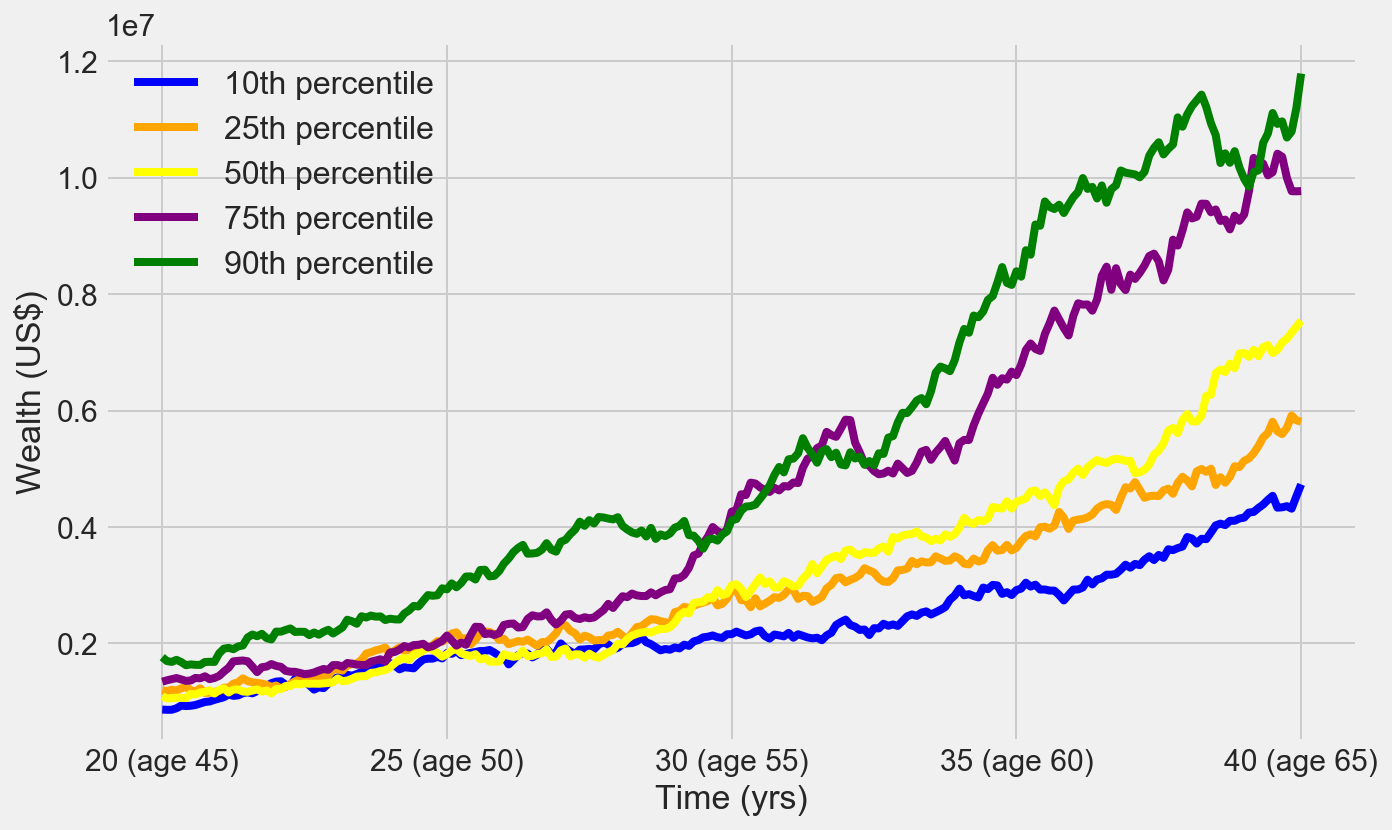

In [205]:
target_retirement_year = 65
graph_wealth_path(wealth, target_retirement_year, n)

As can be seen from the graph above, there is quite a bit of variance in our wealth paths, leading to uncertainty in this strategy. The differences in paths is mainly because US Equities, the main investment, are a riskier asset class that can go both up and down. 

For example, the 90th percentile path would provide the investor with around 1.2mn dollars in wealth at the time of retirement. However, the 10th percentile path would ony provide 400k dollars in wealth. 

The simulation output above can be helpful to provide insights and manage expectations for investment strategies. Although it would not be able to provide exact paths, lacking major nuances, it can show the possiblities and highlight the effects of adapting the strategies. 